In [1]:
#!pip install flask
!pip install flask_restful

In [1]:
import pandas as pd

train_data = pd.read_csv("감정_train.csv")
test_data = pd.read_csv("감정_test.csv")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

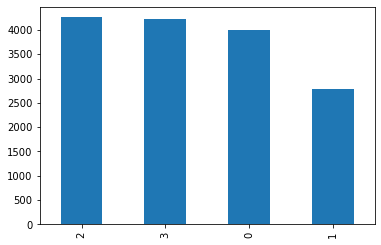

In [3]:
train_data['label'].value_counts().plot(kind='bar')

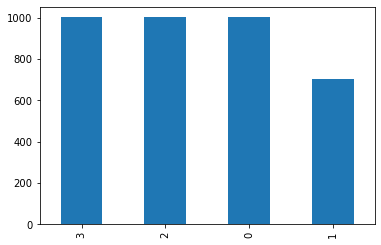

In [4]:
test_data['label'].value_counts().plot(kind='bar')

In [5]:
print(train_data.groupby('label').size().reset_index(name='count'))
print(test_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0   3999
1      1   2787
2      2   4259
3      3   4226
   label  count
0      0   1001
1      1    701
2      2   1001
3      3   1001


In [6]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [7]:
import konlpy 
from konlpy.tag import Okt 
okt = Okt() 
X_train = [] 
for sentence in train_data['title']: 
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_train.append(temp_X) 
    
X_test = [] 
for sentence in test_data['title']: 
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_test.append(temp_X)

In [8]:
from keras.preprocessing.text import Tokenizer 
max_words = 35000 
tokenizer = Tokenizer(num_words = max_words) 
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)

문장의 최대 길이 :  75
문장의 평균 길이 :  7.894178508283675


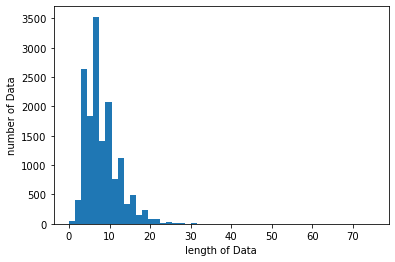

In [9]:
print("문장의 최대 길이 : ", max(len(l) for l in X_train)) 
print("문장의 평균 길이 : ", sum(map(len, X_train))/ len(X_train)) 
plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

문장의 최대 길이 :  48
문장의 평균 길이 :  7.274838012958964


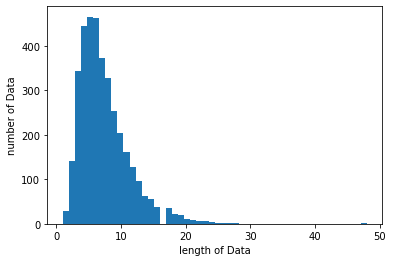

In [10]:
print("문장의 최대 길이 : ", max(len(l) for l in X_test)) 
print("문장의 평균 길이 : ", sum(map(len, X_test))/ len(X_test)) 
plt.hist([len(s) for s in X_test], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

In [11]:
import numpy as np 

y_train = [] 
y_test = [] 



for i in range(len(train_data['label'])): 
    if train_data['label'].iloc[i] == 3:
        y_train.append([0, 0, 0, 1]) 
    elif train_data['label'].iloc[i] == 2: 
        y_train.append([0, 0, 1, 0]) 
    elif train_data['label'].iloc[i] == 1: 
        y_train.append([0, 1, 0, 0]) 
    elif train_data['label'].iloc[i] == 0: 
        y_train.append([1, 0, 0, 0]) 
        
for i in range(len(test_data['label'])): 
    if test_data['label'].iloc[i] == 3:
        y_test.append([0, 0, 0, 1]) 
    elif test_data['label'].iloc[i] == 2: 
        y_test.append([0, 0, 1, 0]) 
    elif test_data['label'].iloc[i] == 1: 
        y_test.append([0, 1, 0, 0]) 
    elif test_data['label'].iloc[i] == 0: 
        y_test.append([1, 0, 0, 0])
y_train = np.array(y_train) 
y_test = np.array(y_test)

In [12]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences 
max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 

X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)

In [13]:
model = Sequential() 
model.add(Embedding(max_words, 100)) 
model.add(LSTM(128))
model.add(Dense(4, activation='softmax')) 

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=12, batch_size=10, validation_split=0.1)

Epoch 1/12
  50/1375 [>.............................] - ETA: 53s - loss: 1.3497 - accuracy: 0.4080

KeyboardInterrupt: 

In [39]:
print("\n 테스트 정확도 : {:.2f}%".format(model.evaluate(X_test, y_test)[1]*100))

116/116 [==============================] - 1s 5ms/step - loss: 1.8987 - accuracy: 0.6814

 테스트 정확도 : 68.14%


In [40]:
predict = model.predict(X_test)

In [41]:
import numpy as np 
predict_labels = np.argmax(predict, axis=1) 
original_labels = np.argmax(y_test, axis=1)

In [42]:
for i in range(20): 
    print("문장 / 단어 : ", test_data['title'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])

문장 / 단어 :  우리모두 준혁이성과 LG선수들이 선전할수 있게 기를 넣어줍시다. /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :   웃긴거 알죠?~ㅋㅋ /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :  덕분에 주방에서 요리하는게 넘 좋아졌어요 /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :    마지막 순간 손가락으로 총을 만들어 쏘실때에는 제가 직접 맞는 것 같습니다. /	 원래 라벨 :  3 /	예측한 라벨 :  2
문장 / 단어 :  어떻게 여성 요리사 보다 더 인기가 많으신지...저도 늘 반찬 만들때 따라하고 있답니다. /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :  우리에게 맛있는 음식을 전하시는 백주부님 당신 멋져 /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :    응원합니다.그리고..사랑합니다.  화이팅!!!! /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :  원호 형님 형님이 올해 우리팀으로 온다고 해서 얼마나 기뻤는지 몰라요 /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :  500일 축하해요 /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :  생일진심으로 축하해요 /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :    축하~!!! /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :  요리가 차~암 쉽쥬~~~~^^ /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :  요리의 매력에 빠졓슈 /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :  예밤 300일 너무너무 축하해요 ^^ /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :   항상 밝은 에너지덕분에 힘이 납니다!!! /	 원래 라벨 :  3 /	예측한 라벨 :  3
문장 / 단어 :   대단하신 우리 백쌤, 화이팅요!! /	 원래 라벨 :  3 /	

In [43]:
def sentiment_predict(new_sentence):
  ang=0
  sad=0
  anx=0
  joy = 0
  num=[]
  maxnum=0
  new_sentence_1 = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence_1 = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence_1]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  predict1 = model.predict(pad_new)
  predict_labels1 = np.argmax(predict1, axis=1)
    
  if(predict_labels1 == 0):
#         print('[분노/혐오]',end=' ')
#         print(new_sentence)
#     ang+=1
        return 0
  elif(predict_labels1 == 1):
#        print('[슬픔]',end=' ')
#        print(new_sentence)
#     sad+=1
        return 1
  elif(predict_labels1 == 2):
#        print('[걱정/불안]',end=' ')
#        print(new_sentence)
#     anx+=1
        return 2
  elif(predict_labels1 == 3):
#        print('[기쁨/긍정]',end=' ')
#        print(new_sentence)
#     joy+=1
        return 3
    

In [44]:
a = 0
b = 0
c = 0
d = 0
def sentiment_predict(new_sentence):
  new_sentence_1 = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence_1 = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence_1]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  predict1 = model.predict(pad_new)
  predict_labels1 = np.argmax(predict1, axis=1)
  if(predict_labels1 == 0):
    global a
    a=a+1
    print('[분노/혐오]',end=' ')
    print(new_sentence)
  elif(predict_labels1 == 1):
    global b
    b=b+1
    print('[슬픔]',end=' ')
    print(new_sentence)
  elif(predict_labels1 == 2):
    global c
    c=c+1
    print('[걱정/불안]',end=' ')
    print(new_sentence)
  elif(predict_labels1 == 3):
    global d
    d=d+1
    print('[기쁨/긍정]',end=' ')
    print(new_sentence)

In [47]:
import csv

def read_data(filename):
    save = []
    f = open(filename,'r')
    data = csv.reader(f)
    for row in data:
         save.append(row[2])
    print(save)
    for i in save:  
        sentiment_predict(i)
    print()
read_data('group.csv')

[' 띠용', ' 갑자기 만들어진 방이 당황스럽구나 ', ' 말좀 해봐 친구들아', ' 밥 먹었어?? ', ' 밥 방금먹었지', ' 응 나도 방금 먹었어', ' 파스타 먹었는데 너무 맛있더라!', ' ㅋㅋㅋㅋ맛있게 먹었니?', ' 헐 파스타 개부러워', ' 존맛이야~', ' 개맛있겠다', ' 말을 잘못해서 미안해 ㅜ', ' 똑바로 해라 한번에;', ' 나는 내일 시험이라 공부중이야ㅠ', ' 이거 언제 다하냐..', ' 과제해야지..', ' 시험기간이라 너무 힘들어..진심 ', ' 진짜 답없다', ' 할거 너무 많아', ' 학기끝나기전까지는 진짜 쉴틈이없다', ' 얼른 종강하고싶다', ' 그러게.. ', ' 종강해도... 팀프로젝트', ' 우리 팀플 그래도 잘 할 수 있을거야', ' 너무 걱정하지마', ' 맞아 열심히 해보자', ' 그래 힘내보자', ' 음 좀 징그러워서 별로 안좋아해', ' 응 나는 좋아해', ' 맞아 엄청 무섭더라고ㄷㄷ', ' 코로나때매 영화도 못보고 ㅜ', ' 엄청 재밌어 나중에 꼭 봐봐', ' 맞아 진짜 존잼이야ㅜ', ' 꼭 봐야겠다', ' 코로나 빨리 잠잠해지면 좋겠어', ' 걱정이 이만저만 아니야', ' 큰일이야.. 언제 잠잠 해질려나', ' 그러게 집에만 있으려니 너무 답답해', ' 나가서 놀고싶다ㅠ', ' 안녕하세요 반가워요', ' 네 안녕하세요', ' 오늘 날씨 좋네요', ' 제 생각에는 별로에요', ' 왜 그렇게 생각하세요?', ' 저는 더위를 많이타서요..', ' 아~ 그렇구나', ' 아 개짜증나네', ' 아 화나', ' 아니 이게 무슨일이야', ' 도와줘 제발', ' 개소리하지말고', ' 과제 때매 막막하다....', ' 발표 잘 됬으면 좋겠다', ' 너무 좋은데?', ' 와 개쩐다 ㅋㅋ', ' ㄹㅇ 쥰내 웃기네 ㅋㅋ', ' 천천히 하고와 ㅎㅎ', ' 역겹네 진짜', ' 돈이 걸려야 겜하는 새끼...', ' 아니 따라갈 수가 없네', ' 저걸 왜 하고 있는거지', ' 아니 이런건 어디서 찾았어 ㅋㅋㅋㅋ', ' 개병대 수준',

In [20]:
from flask import Flask
from flask import request
from flask_restful import Resource, Api, reqparse, abort

app = Flask(__name__)
api = Api(app)

@app.route('/test',methods=["POST"])
def sentimentTest():
    value=request.form['ed_test']
    re = sentiment_predict(value)
    print(re) 
    return str(re)

if __name__=="__main__":
    app.run(host='0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -


2
3
0
2
3
1


192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -


1
0
21

1
3
2
0


192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:25:47] "POST /test HTTP/1.1" 200 -


3
1


192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -


2
0
3
3
2


192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:40] "POST /test HTTP/1.1" 200 -


1
1
2
0
1


192.168.117.1 - - [13/May/2021 14:35:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:41] "POST /test HTTP/1.1" 200 -


1
3
2
3
0
1


192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -


2
3
2
3
0


192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -


1
0
2
1


192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -


1
3
2
0


192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:35:48] "POST /test HTTP/1.1" 200 -


1
1
3


192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -


2
3
0
23



192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:29] "POST /test HTTP/1.1" 200 -


1
10

1
2


192.168.117.1 - - [13/May/2021 14:37:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:30] "POST /test HTTP/1.1" 200 -


1
3
2
0
3
1


192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -


0
3
2
32



192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:35] "POST /test HTTP/1.1" 200 -


11

0
1
2


192.168.117.1 - - [13/May/2021 14:37:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:37:36] "POST /test HTTP/1.1" 200 -


1
20

33

1


192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -


2
0
3
32

1


192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -


1
1
0
2


192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:39:51] "POST /test HTTP/1.1" 200 -


1
2
3
0
3
1


192.168.117.1 - - [13/May/2021 14:40:08] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:08] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:08] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:08] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:08] "POST /test HTTP/1.1" 200 -


2
3
0
2
3


192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -


0
1
1
1


192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:09] "POST /test HTTP/1.1" 200 -


3
1
0
2
3
2
1


192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -


0
2
3
3
2


192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -


1
1
0
1
2


192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:13] "POST /test HTTP/1.1" 200 -


1
3
0
3
2
1


192.168.117.1 - - [13/May/2021 14:40:16] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:16] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:16] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:16] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:16] "POST /test HTTP/1.1" 200 -


2
3
2
3
0


192.168.117.1 - - [13/May/2021 14:40:16] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -


1
1
2
1


192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -


0
1
3
2

192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:40:17] "POST /test HTTP/1.1" 200 -



0
3
1


192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -


3
2
0
23



192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -


11

0
12



192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:41:54] "POST /test HTTP/1.1" 200 -


13

2
3
0
1


192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -


3
0
2
32



192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -


1
0
1
1
1


192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -


3
2
0
3

192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:42:05] "POST /test HTTP/1.1" 200 -



1
2


192.168.117.1 - - [13/May/2021 14:45:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:40] "POST /test HTTP/1.1" 200 -


2
2
3
0
3


192.168.117.1 - - [13/May/2021 14:45:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -


1
1
1
0
2


192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:41] "POST /test HTTP/1.1" 200 -


1
3
2
3
0
1


192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -


0
2
3
2
3


192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:46] "POST /test HTTP/1.1" 200 -


1
1
0
2
1


192.168.117.1 - - [13/May/2021 14:45:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:45:47] "POST /test HTTP/1.1" 200 -


1
3
2
3
0
1


192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -


2
0
2
3
3


192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -


1
1
0
1
2


192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:13] "POST /test HTTP/1.1" 200 -


1
3
0
2
3
1


192.168.117.1 - - [13/May/2021 14:47:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:29] "POST /test HTTP/1.1" 200 -


2
3
2
3
0


192.168.117.1 - - [13/May/2021 14:47:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:29] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:29] "POST /test HTTP/1.1" 200 -


1
0
1
2


192.168.117.1 - - [13/May/2021 14:47:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:30] "POST /test HTTP/1.1" 200 -


1
3
2
0
1
3

192.168.117.1 - - [13/May/2021 14:47:30] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:30] "POST /test HTTP/1.1" 200 -



1


192.168.117.1 - - [13/May/2021 14:47:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:54] "POST /test HTTP/1.1" 200 -


2
3
3
2
0


192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -


1
1
1
0
2


192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:47:55] "POST /test HTTP/1.1" 200 -


2
3
1
0
3
1


192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -


2
0


192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -


3
2
3
0
3
2
3
0
3
2


192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -


2
3
3
3
0
2
2
3


192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -


2
3
2
0
2
1


192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -


1
2
0
1
1


192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -


1
1
0
10



192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -


2
1
1
1


192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -


2
1
1
1
1
0


192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -


2
3
2
1
1
0
2


192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -


13

1
3
02



192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -


3
3
2
1


192.168.117.1 - - [13/May/2021 14:49:58] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -


3
0
1
3


192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -


3
2
2


192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -


0
0
1
2
0
3
3


192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:49:59] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -


1
3
1
2
0


192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -


02

3
3
0
3


192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -


3
1
2
1
3
3
3
0


192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:00] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -


2
1
2
1
0


192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -


0
22

1
1
3


192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -


1
1
10

3


192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:01] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -


1
0
2
2
1
1


192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -


1
1
1


192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -


2
0
3
1
0
2


192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -


2
10

1
1
2
3


192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -


1
2
0
2
2


192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -


2
1
3


192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -


1
0
3
2
2
1
3
2


192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -


2
3
0
21

3


192.168.117.1 - - [13/May/2021 14:50:03] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -


0
1
2
2
1
1


192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:04] "POST /test HTTP/1.1" 200 -


3
3
3


192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -


2
30

3
2


192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -


1
0
1
1
2
1


192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:18] "POST /test HTTP/1.1" 200 -


3
2
2
0
3
1


192.168.117.1 - - [13/May/2021 14:50:39] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:39] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:39] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:39] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:39] "POST /test HTTP/1.1" 200 -


2
0
3
32



192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -


0
12

1
1
1

192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:50:40] "POST /test HTTP/1.1" 200 -



3
2
2
0
3
1


192.168.117.1 - - [13/May/2021 14:51:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:04] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:04] "POST /test HTTP/1.1" 200 -


2
2
3
0
3


192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -


1
0
1
1
2
1


192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:51:05] "POST /test HTTP/1.1" 200 -


3
0
2
2
3
1


192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -


002

3

3
3
20

3


192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -


2
22

3
3
2
2
3
3


192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -


2
0
3
02

3
2


192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -


3
2
0
3
0
2
3
2
2
3
3
0

192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:41] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -


3

1
1
2
1
1
0


192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -


1
1
1
0
0
2
1
1


192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -


1
1
2
1


192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -


1
0
0
1
1
1


192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -


2
1
1
0
2
2
1


192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:42] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -


1
1
1


192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -


0
0
1
1
2
2
1
2


192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -


1
1
2
3
3


192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -


3
0
2
3


192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -


1
2
0


192.168.117.1 - - [13/May/2021 14:55:43] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -


3
32

3
1
2
3


192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -


0
3
2
2
02

3
0
2


192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -


3
0
2
2
3
3
2
0
2
0
3
2
0

192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -


2

3
3
3
3
2
3
3
2


192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -


3
2
3
2
2
0
2
31

0


192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -


0
3
3
3
2
1


192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:45] "POST /test HTTP/1.1" 200 -


2
1
20

3
2
0
2
3
0
2
1
3
0


192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -


1
32

1
0
2


192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -


3
1
2
3
0


192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -


1
1
3
0
1
1


192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:46] "POST /test HTTP/1.1" 200 -


1
1
0
1
1


192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -


2
1
1
2


192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -


0
2
2
3


192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -


32

1
1


192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -


0
2
1
1
1
0


192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:47] "POST /test HTTP/1.1" 200 -


2
0
2
3
3
3
2
0


192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -


2
2
1
0
2
3
3


192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -


1
2
0
3
2
0
32



192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -


33

0
3
0
2
3


192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -


23

2
2


192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -


3
3
1
0
2
0
2
3
3
2


192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -


2
1
1
2
1
1
0
3


192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -


0
3
1
1
1
0


192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:48] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -


2
2
11

2
3
30

3
3
3


192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -


1
22

0
3
2


192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -


3
3
1
0


192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -


2
1
0


192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:49] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -


2
0
2
1
1


192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -


1
0
1
2
1
1
2
1


192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -


2
3
0
3
2


192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:50] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -


3
1
0
3
2
1
0


192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -


0
3
1
3
1
3
2


192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:51] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -


0
2
2
0
3
2
3
3
3
2
2
0
3
0


192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -


2
2
03

2
3
2
3
3


192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -


2
2
3
3
3
2
3
0
2
0
3
0
2
3
2


192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -


2
0
3


192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:53] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -


1
1


192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -


1
1
1
0
0
0
0
1
0
13

1


192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -


1
3
1
2
1
0
2


192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -


0
1
1
1
1
1
2
1
1
0
0
1
2


192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:55] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:

3
1
1
1
1
2
1
2
2


192.168.117.1 - - [13/May/2021 14:55:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:56] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:55:57] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 14:

3
3
3
1
3


192.168.117.1 - - [13/May/2021 15:08:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:35] "POST /test HTTP/1.1" 200 -


3
3
1
3
3


192.168.117.1 - - [13/May/2021 15:08:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:44] "POST /test HTTP/1.1" 200 -


3
1
33

3


192.168.117.1 - - [13/May/2021 15:08:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:52] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:08:52] "POST /test HTTP/1.1" 200 -


3
3
1
3
3


192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -


1
3
3
3
3
3
3


192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -


3
3
3
3
3
31
3

1
3
3
3


192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:17] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -


3
3
1
1
3


192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -


33

3
3
13

3
3
1
3
3


192.168.117.1 - - [13/May/2021 15:09:18] "POST /test HTTP/1.1" 200 -


1


192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -


1
3
3
3
3
3
3
3
1


192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -


3
3
33

1
3
3
3


192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -


31

3


192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -


3
1
3
1


192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:44] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -


3
3
3
3


192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -


3
3
13

3
1
3

192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -



3
3
3
33



192.168.117.1 - - [13/May/2021 15:09:45] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -


3
1
3
1
3
3
3


192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -


3
1
3
3
33

1
3


192.168.117.1 - - [13/May/2021 15:09:46] "POST /test HTTP/1.1" 200 -


3


192.168.117.1 - - [13/May/2021 15:09:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:54] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:09:54] "POST /test HTTP/1.1" 200 -


3
1
3
3
3


192.168.117.1 - - [13/May/2021 15:10:15] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:10:15] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:10:15] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:10:15] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:10:15] "POST /test HTTP/1.1" 200 -


3
3
3
1
3


192.168.117.1 - - [13/May/2021 15:10:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:10:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:10:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:10:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:10:35] "POST /test HTTP/1.1" 200 -


3
3
3
3
1


192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -


3
1


192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -


3
3
3


192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -


3
3
3
3
13



192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -


3
3
3
3
3
3
1
3


192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:31] "POST /test HTTP/1.1" 200 -


3
3
1
3
3
1
3
1
3
3
3


192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -


3
3
3
1
1
3
3
3
3
1


192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -


3
3
3
1
3


192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -


3
3
3
3
3


192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -


3
1


192.168.117.1 - - [13/May/2021 15:12:32] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -


3
3
3
1
3
3


192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -


3
3
3
1
3


192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -


1
3
3
1
3


192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:33] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -


3
3
3
3
1
3


192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -


1
3
3
3
3
3


192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:34] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -


1
3
3
3
3
3


192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:35] "POST /test HTTP/1.1" 200 -


3
1


192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -


3
3
1
3
3
1
3
1
3
3


192.168.117.1 - - [13/May/2021 15:12:36] "POST /test HTTP/1.1" 200 -


3


192.168.117.1 - - [13/May/2021 15:16:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:16:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:16:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:16:18] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:16:18] "POST /test HTTP/1.1" 200 -


3
1
3
3
3


192.168.117.1 - - [13/May/2021 15:16:37] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:16:37] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:16:37] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:16:37] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:16:37] "POST /test HTTP/1.1" 200 -


3
3
1
3
3


192.168.117.1 - - [13/May/2021 15:17:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:17:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:17:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:17:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:17:02] "POST /test HTTP/1.1" 200 -


3
1
3
3
3


192.168.117.1 - - [13/May/2021 15:22:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:02] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:02] "POST /test HTTP/1.1" 200 -


3
1
3
3
3


192.168.117.1 - - [13/May/2021 15:22:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:05] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:05] "POST /test HTTP/1.1" 200 -


3
1
3
3
3


192.168.117.1 - - [13/May/2021 15:22:08] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:08] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:08] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:08] "POST /test HTTP/1.1" 200 -
192.168.117.1 - - [13/May/2021 15:22:08] "POST /test HTTP/1.1" 200 -


3
3
1
3
3
